In [ ]:
#Ханаев Антон ИАД5
#0.98474

In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
os.listdir('../input/funny-name')

['__results__.html',
 'custom.css',
 'imgs.npy',
 '__notebook__.ipynb',
 'labels.npy',
 '__results___files',
 '__output__.json']

In [3]:
os.listdir('../input/chinese-char-recognition-smmo19')

['train-2.npy',
 'test.npy',
 'train-4.npy',
 'random_labels.csv',
 'train-3.npy',
 'train-1.npy']

In [4]:
path_original = Path('../input/chinese-char-recognition-smmo19')
path_woduplicates = Path('../input/funny-name')

In [5]:
train_imgs = np.load(path_woduplicates / 'imgs.npy', allow_pickle=True)
train_labels = np.load(path_woduplicates / 'labels.npy', allow_pickle=True)

In [6]:
sample_img = train_imgs[0]
sample_label = train_labels[0]

[]

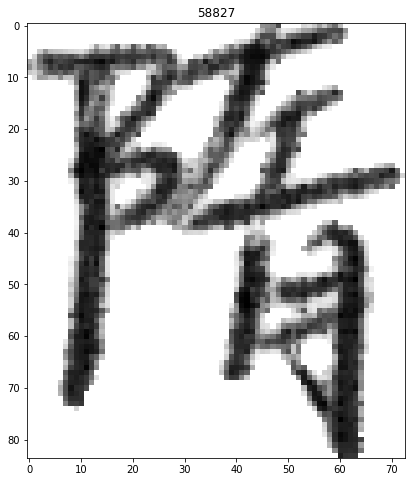

In [7]:
plt.figure(figsize=(12, 8))
plt.title(str(sample_label))
plt.imshow(sample_img, cmap='Greys_r')
plt.plot()

<Figure size 1440x1440 with 0 Axes>

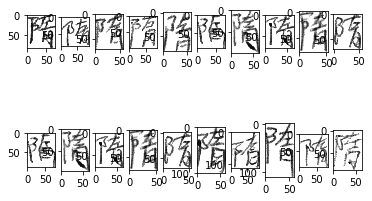

In [8]:
plt.figure(figsize=(20, 20))
fig, axs = plt.subplots(2, 10)
for i in range(2):
    for j in range(10):
        axs[i, j].imshow(train_imgs[i*5+j], cmap='Greys_r')
plt.show()

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
seed = 2324
X_train, X_val, y_train, y_val = train_test_split(train_imgs, train_labels, test_size=0.1, random_state=seed)

In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
class ChineseCharactersDataset(Dataset):
    def __init__(self, imgs, labels, transform=None):
        self.imgs = imgs
        unq = np.unique(labels)
        self.labels = labels
        self.label_dict = {unq[i]:i for i in range(len(unq))}
        self.model_out_to_class = {i: unq[i] for i in range(len(unq))}
        
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img = Image.fromarray(self.imgs[idx])
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        #img = img * 2 / 255 - 1
        return img, self.label_dict[label]

In [14]:
img_size = (54, 54)
train_transform = torchvision.transforms.Compose([torchvision.transforms.RandomAffine((-10, 10), translate=(0.1, 0.1), scale=(0.8, 1.2), shear=(-10, 10), fillcolor=255), torchvision.transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,)), transforms.RandomErasing(p=0.2)])
test_transform = torchvision.transforms.Compose([torchvision.transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))])

train_dataset = ChineseCharactersDataset(X_train, y_train, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=4)

val_dataset = ChineseCharactersDataset(X_val, y_val, transform=test_transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1024, shuffle=True, num_workers=4)

In [15]:
import torch.nn as nn
import torch.nn.functional as F

In [16]:
class ChineseCharacterCNN(nn.Module):
    def __init__(self):
        
        super(ChineseCharacterCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 64, (7, 7))
        self.bn1 = nn.BatchNorm2d(64)
        self.lrelu1 = nn.LeakyReLU(0.1)
        #self.mp1 = nn.MaxPool2d((2, 2), 2)
        #self.do1 = nn.Dropout(0.5)
        
        self.conv2 = nn.Conv2d(64, 64, (7, 7), padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.lrelu2 = nn.LeakyReLU(0.1)
        self.mp2 = nn.MaxPool2d((2, 2), 2)
        self.do2 = nn.Dropout(0.4)
        
        self.conv3 = nn.Conv2d(64, 128, (5,5), padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.lrelu3 = nn.LeakyReLU(0.1)
        #self.mp3 = nn.MaxPool2d((2, 2), 2)
        #self.do3 = nn.Dropout(0.5)
        
        self.conv4 = nn.Conv2d(128, 128, (3,3), padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.lrelu4 = nn.LeakyReLU(0.1)
        self.mp4 = nn.MaxPool2d((2, 2), 2)
        self.do4 = nn.Dropout(0.4)
        
        self.conv5 = nn.Conv2d(128, 256, (3,3), padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.lrelu5 = nn.LeakyReLU(0.1)
        #self.mp3 = nn.MaxPool2d((2, 2), 2)
        #self.do3 = nn.Dropout(0.5)
        
        self.conv6 = nn.Conv2d(256, 256, (3,3), padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.lrelu6 = nn.LeakyReLU(0.1)
        self.mp6 = nn.MaxPool2d((2, 2), 2)
        self.do6 = nn.Dropout(0.4)
        
        
                
        self.fc1 = nn.Linear(5 * 5 * 256, 4096)
        self.bn_fc1 = nn.BatchNorm1d(4096)
        self.act1 = nn.ELU()
        #self.do_fc1 = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(4096, 2048)
        self.bn_fc2 = nn.BatchNorm1d(2048)
        self.act2 = nn.ELU()
        #self.do_fc2 = nn.Dropout(0.2)
        
        self.fc3 = nn.Linear(2048, 1000)
    
    def forward(self, x):
        #x = x * 2 - 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.lrelu1(x)
        #x = self.mp1(x)
        #x = self.do1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.lrelu2(x)
        x = self.mp2(x)
        x = self.do2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.lrelu3(x)
        #x = self.mp3(x)
        #x = self.do3(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.lrelu4(x)
        x = self.mp4(x)
        x = self.do4(x)
        
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.lrelu5(x)
        #x = self.mp3(x)
        #x = self.do3(x)
        
        x = self.conv6(x)
        x = self.bn6(x)
        x = self.lrelu6(x)
        x = self.mp6(x)
        x = self.do6(x)
        
        #print(x.shape)

        x = x.view(-1, 5 * 5 * 256)
        
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = self.act1(x)
        #x = self.do_fc1(x)
        
        x = self.fc2(x)
        x = self.bn_fc2(x)
        x = self.act2(x)
        #x = self.do_fc2(x)
        
        x = self.fc3(x)
        
        return x

In [17]:
cnn = ChineseCharacterCNN().to(device)

In [18]:
import torch.optim as optim
import time

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=600, gamma=0.5, last_epoch=-1)

In [19]:
epochs = 30
history = []
for epoch in range(epochs):
    epoch_start = time.time()
    print("Epoch: {}/{}".format(epoch+1, epochs))
     
    # Set to training mode
    cnn.train()
     
    # Loss and Accuracy within the epoch
    train_loss = 0.0
    train_acc = 0.0
     
    valid_loss = 0.0
    valid_acc = 0.0
 
    for i, (inputs, labels) in enumerate(train_loader):
 
        inputs = inputs.to(device)
        labels = labels.to(device)
         
        optimizer.zero_grad()
         
        outputs = cnn(inputs)
         
        loss = criterion(outputs, labels)
         
        loss.backward()
         
        optimizer.step()
        scheduler.step()
         
        train_loss += loss.item() * inputs.size(0)
         
        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
         
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
         
        train_acc += acc.item() * inputs.size(0)
         
        #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))
    else:
        with torch.no_grad():
 
            cnn.eval()

            for j, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = cnn(inputs)

                loss = criterion(outputs, labels)

                valid_loss += loss.item() * inputs.size(0)

                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                valid_acc += acc.item() * inputs.size(0)


        avg_train_loss = train_loss/len(train_dataset) 
        avg_train_acc = train_acc/float(len(train_dataset))

        avg_valid_loss = valid_loss/len(val_dataset) 
        avg_valid_acc = valid_acc/float(len(val_dataset))

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))

Epoch: 1/30
Epoch : 000, Training: Loss: 3.1757, Accuracy: 36.8544%, 
		Validation : Loss : 0.6075, Accuracy: 83.4735%, Time: 73.9724s
Epoch: 2/30
Epoch : 001, Training: Loss: 0.9730, Accuracy: 74.7500%, 
		Validation : Loss : 0.3229, Accuracy: 90.6284%, Time: 72.3480s
Epoch: 3/30
Epoch : 002, Training: Loss: 0.6830, Accuracy: 81.6646%, 
		Validation : Loss : 0.2927, Accuracy: 91.5475%, Time: 72.4872s
Epoch: 4/30
Epoch : 003, Training: Loss: 0.5660, Accuracy: 84.4914%, 
		Validation : Loss : 0.2304, Accuracy: 93.6321%, Time: 72.5485s
Epoch: 5/30
Epoch : 004, Training: Loss: 0.4059, Accuracy: 88.7267%, 
		Validation : Loss : 0.1514, Accuracy: 95.7647%, Time: 73.4602s
Epoch: 6/30
Epoch : 005, Training: Loss: 0.3410, Accuracy: 90.4335%, 
		Validation : Loss : 0.1137, Accuracy: 96.8761%, Time: 72.4808s
Epoch: 7/30
Epoch : 006, Training: Loss: 0.3229, Accuracy: 90.9121%, 
		Validation : Loss : 0.1043, Accuracy: 96.9482%, Time: 72.4701s
Epoch: 8/30
Epoch : 007, Training: Loss: 0.3078, Accura

In [20]:
h = np.array(history)
r = np.arange(h.shape[0])

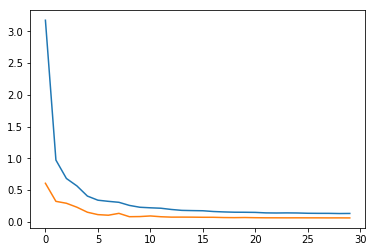

In [21]:
plt.plot(r, h[:, 0])
plt.plot(r, h[:, 1])

In [22]:
test = np.load(path_original / 'test.npy', allow_pickle=True)

In [23]:
def predict(model, test_image_name, transform):
 
    test_image = Image.fromarray(test_image_name)     
    test_image_tensor = transform(test_image)
 
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 1, 54, 54).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 1, 54, 54)
     
    with torch.no_grad():
        model.eval()
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(1, dim=1)
    return topclass.cpu().numpy()[0][0]

In [24]:
train_dataset.model_out_to_class[predict(cnn, sample_img, test_transform)]

58827

In [25]:
sample_label

58827

In [26]:
preds = []
for i in range(len(test)):
    pred = predict(cnn, test[i], test_transform)
    preds.append(train_dataset.model_out_to_class[pred])

In [27]:
np_preds = np.array(preds)

In [28]:
subm = pd.read_csv(path_original / 'random_labels.csv')

In [29]:
subm['Category'] = np_preds

In [30]:
np_preds.max()

65238

In [31]:
subm.to_csv('subm.csv', index=False)

In [32]:
tr = pd.read_csv('subm.csv')

In [33]:
tr

,Id,Category
0,1,63955
1,2,64432
2,3,64709
3,4,64177
4,5,61881
...,...,...
83242,83243,61877
83243,83244,64463
83244,83245,59837
83245,83246,60602


In [34]:
subm

,Id,Category
0,1,63955
1,2,64432
2,3,64709
3,4,64177
4,5,61881
...,...,...
83242,83243,61877
83243,83244,64463
83244,83245,59837
83245,83246,60602
